In [39]:
n_try = 1

In [40]:
from google.colab import drive

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [41]:
from os.path import isdir
import tensorflow as tf
import numpy as np
import os
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import MaxPooling2D

import tensorflow as tf
from tensorflow.keras.layers import Dense
from tensorflow.keras.regularizers import L1L2

from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import MaxPool2D

from tensorflow.keras.optimizers import Adam

import pandas as pd

# Data preparation

In [42]:

class DataProperties:
    main_dir = '/content/drive/MyDrive/ML/Datasets/5.Unox/'
    # validation_dir = main_dir + 'validation/'
    train_dir = main_dir + 'train/'
    test_dir = main_dir + 'test/'

    hackathon_dir = f'/content/drive/MyDrive/ML/Unox/{n_try}/'
    model_save_dir = hackathon_dir + 'Models/'
    histories_dir = hackathon_dir + 'Histories/'


def make_dirs(dirs):
    for dir in dirs:
        if not isdir(dir):
            os.mkdir(dir)


make_dirs(
    [
     DataProperties.hackathon_dir,
     DataProperties.train_dir,
     # DataProperties.validation_dir,
     DataProperties.model_save_dir,
     DataProperties.histories_dir,
    ]
)

assert(isdir(DataProperties.main_dir))
assert(isdir(DataProperties.model_save_dir))

assert(isdir(DataProperties.train_dir))
# assert(isdir(DataProperties.validation_dir))
assert(isdir(DataProperties.histories_dir))

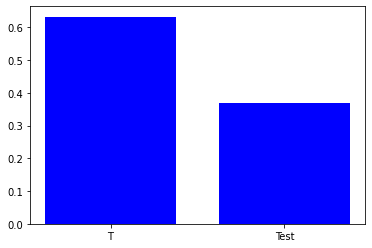

In [43]:
def calc_files(directory):
    total_files = 0

    for base, _, files in os.walk(directory):
        # print('Searching in : ',base)
        for _ in files:
            total_files += 1
    return total_files

x = ['T', 'Test']
y = [
     calc_files(dir) for dir in [
                                 DataProperties.train_dir, 
                                 # DataProperties.validation_dir,
                                 DataProperties.test_dir]
]

y = np.array(y)
y = y / sum(y)
# y[0] = y[0] / sum(y)
# y[1] = y[1] / sum(y)

fig, ax = plt.subplots()
ax.bar(x, y, width = 0.75, color = 'blue')
plt.show()

In [44]:
target_shape = (256, 256)

train_batch_size = 16

width_shift_range = 0.11
height_shift_range = 0.11
rotation_range = 0.2
zoom_range = [0.85, 1.15]

In [45]:
train_use = 1
validation_split = 0.3

def preprocess(image):
    image = image / 255.
    return image

train_generator = ImageDataGenerator(
    validation_split = validation_split, # 1 - train_use,

    preprocessing_function = preprocess,
    # samplewise_center = 
    # featurewise_center = 

    width_shift_range = width_shift_range,
    height_shift_range = height_shift_range,
    rotation_range = rotation_range,
    horizontal_flip = True,
    vertical_flip = True,

    # brightness_range = 
    zoom_range = zoom_range
)

train_flow = train_generator.flow_from_directory(
    directory = DataProperties.train_dir,

    target_size = target_shape,
    color_mode = 'rgb',
    # classes = 
    class_mode = 'sparse',
    batch_size = train_batch_size,
    subset = 'training',
    shuffle = True,
    seed = 123
)

val_flow = train_generator.flow_from_directory(
    directory = DataProperties.train_dir,

    target_size = target_shape,
    color_mode = 'rgb',
    # classes = 
    class_mode = 'sparse',
    batch_size = train_batch_size,
    subset = 'validation',
    shuffle = False,
    seed = 123
)

print(f'Use {train_flow.n} images for train flow')
print(f'Use {val_flow.n} images for validation flow')

Found 122 images belonging to 2 classes.
Found 50 images belonging to 2 classes.
Use 122 images for train flow
Use 50 images for validation flow


In [50]:
# val_use = 1  # 0.4

# val_generator = ImageDataGenerator(
#     validation_split = 1 - val_use,

#     preprocessing_function = preprocess,
#     # samplewise_center = 
#     # featurewise_center = 

#     width_shift_range = width_shift_range,
#     height_shift_range = height_shift_range,
#     rotation_range = rotation_range,
#     horizontal_flip = True,
#     vertical_flip = True,

#     # brightness_range = 
#     zoom_range = zoom_range
# )

# val_flow = val_generator.flow_from_directory(
#     directory = DataProperties.validation_dir,

#     target_size = target_shape,
#     color_mode = 'rgb',
#     # classes = 
#     class_mode = 'sparse',
#     # batch_size = None,
#     subset = 'training',
#     shuffle = False,
#     seed = 123
# )

# print(f'Use {val_flow.n} images for validation flow')

In [51]:
test_use = 1

test_generator = ImageDataGenerator(
    validation_split = 1 - test_use,

    preprocessing_function = preprocess,
    # samplewise_center = 
    # featurewise_center = 

    # width_shift_range = 2,
    # height_shift_range = 2,
    # rotation_range = 0.5,
    # horizontal_flip = True,
    # vertical_flip = True,

    # brightness_range = 
    # zoom_range = [-0.2, 0.2]
)

test_flow = test_generator.flow_from_directory(
    directory = DataProperties.test_dir,

    target_size = target_shape,
    color_mode = 'rgb',
    # classes = 
    class_mode = 'sparse',
    # batch_size = None,
    subset = 'training',
    shuffle = False,
    seed = 123
)

print(f'Use {test_flow.n} images for test flow')

Found 100 images belonging to 2 classes.
Use 100 images for test flow


In [52]:
def visualize(batch, labels, n_subplots, class_indices, figsize = (15, 15)):
    plt.figure(figsize = figsize)
    for i in range(n_subplots): #(batch_size):
        ax = plt.subplot(
            int(np.sqrt(n_subplots)), 
            int(np.sqrt(n_subplots)), 
            i + 1
        )
        plt.imshow(batch[i])
        plt.title(labels[i])
        # plt.title(get_class_name(class_indices, labels[i]))
        plt.axis("off")


def visualize_flow(n, flow):

    how_many_to_show = n
    # flow = train_flow
    for _ in range(1):
        batch, labels = flow.next()
        print(batch.shape, np.max(batch))
        assert np.max(batch) <= 1.01
        assert np.min(batch) >= 0.0
        
        visualize(
            batch,
            labels,
            how_many_to_show,
            class_indices = flow.class_indices,
            figsize=(10, 10)
        )

(16, 256, 256, 3) 1.0


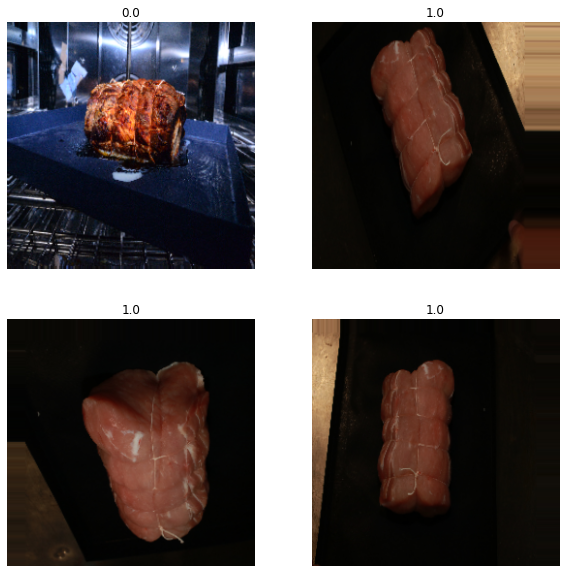

In [53]:
visualize_flow(
    4,
    train_flow
)

# visualize_flow(
#     4, 
#     val_flow
# )

In [54]:
def check_class_balance(flow):
    len_zeros = len(flow.classes[flow.classes == 0])
    len_ones = len(flow.classes[flow.classes == 1])

    print(f'{len_zeros / flow.n}')
    print(len_ones / flow.n)

check_class_balance(train_flow)
check_class_balance(val_flow)
check_class_balance(test_flow)

0.4262295081967213
0.5737704918032787
0.42
0.58
0.5
0.5


# Model preparation

In [61]:
def construct_cnn(input_shape):
    model = tf.keras.models.Sequential()

    model.add(Conv2D(filters = 96, kernel_size = (50, 50), strides = 4, padding = 'valid', activation = 'relu', input_shape = (256, 256, 3)))
    model.add(MaxPooling2D(pool_size = (3, 3), strides = (2, 2), padding = 'valid', data_format = None))

    model.add(Conv2D(filters = 96, kernel_size = (6, 6), strides = 4, padding = 'valid', activation = 'relu', input_shape = (256, 256, 3)))
    model.add(MaxPooling2D(pool_size = (3, 3), strides = (2, 2), padding = 'valid', data_format = None))

    model.add(Flatten())
    model.add(Dense(10, activation = 'relu'))
    model.add(Dense(1, activation= 'sigmoid'))

    model.compile(
        # optimizer = 'sgd',
        optimizer = Adam(learning_rate = 0.001),
        metrics = ['accuracy'],
        loss = 'binary_crossentropy'
    )

    return model

In [62]:
def construct_vgg16(input_shape):
    model = tf.keras.models.Sequential()
    model.add(Conv2D(input_shape=(input_shape),filters=64,kernel_size=(3,3),padding="same", activation="relu", kernel_initializer = 'he_normal'))
    model.add(Conv2D(filters=64,kernel_size=(3,3),padding="same", activation="relu", kernel_initializer = 'he_normal'))
    model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
    
    model.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu", kernel_initializer = 'he_normal'))
    model.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu", kernel_initializer = 'he_normal'))
    model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
    
    model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu", kernel_initializer = 'he_normal'))
    model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu", kernel_initializer = 'he_normal'))
    model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu", kernel_initializer = 'he_normal'))
    model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
    
    model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu", kernel_initializer = 'he_normal'))
    model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu", kernel_initializer = 'he_normal'))
    model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu", kernel_initializer = 'he_normal'))
    model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
    
    model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu", kernel_initializer = 'he_normal'))
    model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu", kernel_initializer = 'he_normal'))
    model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu", kernel_initializer = 'he_normal'))
    model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
    
    model.add(Flatten())
    model.add(Dense(units=4096,activation="relu"))
    model.add(Dense(units=4096,activation="relu"))
    model.add(Dense(units=1, activation="sigmoid"))

    model.compile(
        metrics = 'accuracy',
        loss = 'binary_crossentropy',
        optimizer = 'sgd'
    )

    return model

In [63]:
def construct_model(name, input_shape):
    if name == 'CNN':
        return construct_cnn(input_shape)

    if name == 'VGG16':
        return construct_vgg16(input_shape)

In [64]:
def calc_steps(flow):
    return flow.n // flow.batch_size

train_steps = calc_steps(train_flow)
val_steps = calc_steps(val_flow)
test_steps = calc_steps(test_flow)


def fit_models(models_dict, stopper, epochs = 50):
    histories = {}
    for model_name, model in models_dict.items():
        print(f'fitting {model_name}')

        histories[model_name] = model.fit(
            train_flow,
            steps_per_epoch = train_steps,

            validation_data = val_flow,
            validation_steps = val_steps,

            epochs = epochs,
            callbacks = [stopper]
        )
    return histories

In [65]:
models = {
    'CNN': construct_model('CNN', input_shape = (target_shape[0], target_shape[1], 3)),
    # 'VGG16': construct_model('VGG16', input_shape = (target_shape[0], target_shape[1], 3))
}

In [66]:
early_stopper = EarlyStopping(
    monitor = 'val_loss',
    mode = 'min',
    patience = 3
)

histories = fit_models(
    {'CNN': models['CNN']},
    stopper = early_stopper,
    epochs = 20
)

fitting CNN
Epoch 1/20
7/7 [==============================] - 68s 10s/step - loss: 1.1139 - accuracy: 0.4151 - val_loss: 0.8284 - val_accuracy: 0.5833
Epoch 2/20
7/7 [==============================] - 62s 9s/step - loss: 0.8349 - accuracy: 0.5094 - val_loss: 0.6626 - val_accuracy: 0.5000
Epoch 3/20
7/7 [==============================] - 60s 9s/step - loss: 0.6069 - accuracy: 0.6698 - val_loss: 0.4468 - val_accuracy: 0.9375
Epoch 4/20
7/7 [==============================] - 61s 9s/step - loss: 0.4852 - accuracy: 0.8585 - val_loss: 0.5045 - val_accuracy: 0.8958
Epoch 5/20
7/7 [==============================] - 60s 9s/step - loss: 0.3609 - accuracy: 0.8868 - val_loss: 0.3841 - val_accuracy: 0.9375
Epoch 6/20
7/7 [==============================] - 62s 9s/step - loss: 0.2177 - accuracy: 0.9375 - val_loss: 0.4825 - val_accuracy: 0.9375
Epoch 7/20
7/7 [==============================] - 60s 9s/step - loss: 0.2370 - accuracy: 0.9057 - val_loss: 0.3848 - val_accuracy: 0.9375
Epoch 8/20
7/7 [=====

In [71]:
models['CNN'].evaluate(val_flow)

4/4 [==============================] - 16s 3s/step - loss: 1.0014 - accuracy: 0.8600


[1.0013846158981323, 0.8600000143051147]

In [ ]:
models['CNN'].evaluate(test_flow)

# Another model

In [ ]:
histories_vgg16 = fit_models(
    {'VGG16': models['VGG16']},
    stopper = early_stopper,
    epochs = 2
)

fitting VGG16
Epoch 1/5
  9/128 [=>............................] - ETA: 36:36 - loss: 0.9175 - accuracy: 0.5556

KeyboardInterrupt: ignored

# Saving models

In [67]:
def save_models(models_dict):

    for model_name, model in models_dict.items():
        model.save(
            f'{DataProperties.model_save_dir}{model_name}'
        )

save_models(
    {
        'CNN': models['CNN']
    }
)

INFO:tensorflow:Assets written to: /content/drive/MyDrive/ML/Unox/1/Models/CNN/assets


# Save histories

In [68]:
def save_histories(hist_dict, save_dir):
    for model_name, hist in hist_dict.items():
        df = pd.DataFrame(hist.history)
        df.to_csv(f'{save_dir}{model_name}_history.csv')

save_histories(
    histories,
    save_dir = DataProperties.histories_dir
)